In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
trip_2207 = pd.read_csv("202207-divvy-tripdata.csv")
trip_2207['started_at'] = pd.to_datetime(trip_2207['started_at'], format='%Y-%m-%d %H:%M:%S')
trip_2207['ended_at'] = pd.to_datetime(trip_2207['ended_at'], format='%Y-%m-%d %H:%M:%S')
trip_2207.loc[:,"Weekday"] = trip_2207['started_at'].dt.day_name()
trip_2207['calendar_week'] = trip_2207['started_at'].dt.isocalendar().week
# Extract the hour from the 'started_at' column
trip_2207['start_hour'] = trip_2207['started_at'].dt.hour

# Group by the required columns and count the trips
trip_counts = trip_2207.groupby(['start_station_id', 'Weekday', 'calendar_week', 'start_hour']).size().reset_index(name='trip_count')
trip_counts

start_station_id    Weekday  calendar_week  start_hour  trip_count
0                021320     Friday             26          10           1
1                021320     Friday             26          14           1
2                021320     Friday             26          16           1
3                021320     Friday             27          11           1
4                021320     Friday             28          11           1
...                 ...        ...            ...         ...         ...
208635     chargingstx5  Wednesday             30          18           5
208636     chargingstx5  Wednesday             30          19           8
208637     chargingstx5  Wednesday             30          20           5
208638     chargingstx5  Wednesday             30          21           5
208639     chargingstx5  Wednesday             30          23           1

[208640 rows x 5 columns]

In [3]:
# Filter out weekends for afterwards analysis
trip_counts_weekdays = trip_counts[~trip_counts['Weekday'].isin(['Saturday', 'Sunday'])]
trip_counts_weekdays
trip_counts_weekdays.loc[(trip_counts_weekdays['start_station_id']=='021320')]
unique_station_count = trip_counts_weekdays["start_station_id"].nunique()
print(unique_station_count)

1127


In [57]:
#test in station level the stationarity across workingdays and weeks
hourly_demand_stationid_pivot = trip_counts_weekdays.pivot_table(index=['start_station_id', 'Weekday', 'calendar_week'],
                                               columns='start_hour',
                                               values='trip_count',
                                               fill_value=0).reset_index()

# Resetting column names after pivot
hourly_demand_stationid_pivot.columns.name = None
hourly_demand_stationid_pivot.columns = ['start_station_id', 'Weekday', 'calendar_week'] + [str(i) for i in range(24)]

# Saving or displaying the resulting DataFrame
hourly_demand_stationid_pivot

start_station_id    Weekday  calendar_week  0  1  2  3  4  5  6  ...   
0               021320     Friday             26  0  0  0  0  0  0  0  ...  \
1               021320     Friday             27  0  0  0  0  0  0  0  ...   
2               021320     Friday             28  0  0  0  0  0  0  0  ...   
3               021320     Friday             29  0  0  0  0  0  0  0  ...   
4               021320     Friday             30  0  0  0  0  0  0  0  ...   
...                ...        ...            ... .. .. .. .. .. .. ..  ...   
16065     chargingstx5    Tuesday             30  0  0  0  0  0  1  0  ...   
16066     chargingstx5  Wednesday             27  0  0  0  0  0  0  0  ...   
16067     chargingstx5  Wednesday             28  2  1  0  0  0  0  0  ...   
16068     chargingstx5  Wednesday             29  0  0  0  0  0  0  0  ...   
16069     chargingstx5  Wednesday             30  1  0  0  0  0  1  3  ...   

       14  15  16  17  18  19  20  21  22  23  
0       1   0   1   0   0   0   0   0   0   0  
1       0   0   0   0   0   0   0   0   0   0  
2       1   0   0   0   0   0   0   0   0   1  
3       0   0   2   3   0   0   0   0   0   0  
4       0   0   0   0   1   0   0   0   0   1  
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
16065   2   5   1   4   8  11   8   1   6   0  
16066   0   0   0   0   1   1   0   0   0   0  
16067   6   2   2   6   9   1   3   2   2   3  
16068   0   0   9   7   9   5   7   4   5   0  
16069   2   1   5   4   5   8   5   5   0   1  

[16070 rows x 27 columns]

In [69]:
trip_counts.loc[(trip_counts['start_station_id']=='021320')&(trip_counts['Weekday']=='Sunday')]

start_station_id Weekday  calendar_week  start_hour  trip_count
32           021320  Sunday             27          16           1
33           021320  Sunday             29          14           1

In [4]:
# Group by 'start_station_id' and 'start_hour' and calculate the median of 'trip_count' for each group,only in workingday
median_trip_counts = trip_counts_weekdays.groupby(['start_station_id', 'start_hour'])['trip_count'].median().reset_index(name='median_trip_count')

# Now, 'median_trip_counts' will have the median trip count for each station and hour slot.
median_trip_counts


start_station_id  start_hour  median_trip_count
0               021320           6                1.0
1               021320           7                1.0
2               021320           8                1.0
3               021320          10                1.0
4               021320          11                1.0
...                ...         ...                ...
16172     chargingstx5          19                5.0
16173     chargingstx5          20                3.0
16174     chargingstx5          21                3.0
16175     chargingstx5          22                3.0
16176     chargingstx5          23                2.5

[16177 rows x 3 columns]

In [6]:
# Pivot the table with 'start_station_id' as the index, the hours as columns, and median trip counts as values
median_pivot_table = median_trip_counts.pivot(index='start_station_id', columns='start_hour', values='median_trip_count')
median_pivot_table
# The resulting pivot_table will have station IDs as the index and hours 0-24 as the columns with the median trip counts as values.


start_hour         0    1    2    3   4    5    6    7    8    9   ...   14   
start_station_id                                                   ...        
021320            NaN  NaN  NaN  NaN NaN  NaN  1.0  1.0  1.0  NaN  ...  1.0  \
1011              1.0  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ...  2.0   
1012              NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
1013              NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
1016              NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
...               ...  ...  ...  ...  ..  ...  ...  ...  ...  ...  ...  ...   
chargingstx0      NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN  ...  1.0   
chargingstx1      1.0  1.5  1.0  NaN NaN  1.0  1.0  2.0  2.5  2.5  ...  3.0   
chargingstx3      1.0  1.0  1.0  NaN NaN  1.0  1.0  3.0  4.0  2.0  ...  3.0   
chargingstx4      NaN  5.0  NaN  NaN NaN  1.0  1.0  NaN  NaN  NaN  ...  NaN   
chargingstx5      1.5  1.0  1.5  1.0 NaN  1.0  1.0  3.0  1.0  2.0  ...  2.0   

start_hour         15   16   17   18   19   20   21   22   23  
start_station_id                                               
021320            1.0  1.0  1.5  1.0  NaN  NaN  1.0  NaN  1.0  
1011              1.0  1.0  1.0  NaN  NaN  1.0  1.0  1.5  1.0  
1012              NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  
1013              NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  1.0  
1016              NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  
chargingstx0      NaN  2.0  1.0  4.0  2.0  4.0  NaN  6.0  2.0  
chargingstx1      2.0  3.0  7.0  8.0  6.0  4.5  3.0  3.0  2.0  
chargingstx3      3.0  5.0  5.5  8.0  5.0  5.0  3.0  2.0  1.0  
chargingstx4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
chargingstx5      2.0  3.0  5.5  5.0  5.0  3.0  3.0  3.0  2.5  

[1127 rows x 24 columns]

In [7]:
median_demand_normalized_row = median_pivot_table.div(median_pivot_table.sum(axis=1), axis=0)
median_demand_normalized_row

start_hour              0         1         2         3   4         5    
start_station_id                                                         
021320                 NaN       NaN       NaN       NaN NaN       NaN  \
1011              0.080000       NaN       NaN       NaN NaN       NaN   
1012                   NaN       NaN       NaN       NaN NaN       NaN   
1013                   NaN       NaN       NaN       NaN NaN       NaN   
1016                   NaN       NaN       NaN       NaN NaN       NaN   
...                    ...       ...       ...       ...  ..       ...   
chargingstx0           NaN       NaN       NaN       NaN NaN       NaN   
chargingstx1      0.014925  0.022388  0.014925       NaN NaN  0.014925   
chargingstx3      0.015038  0.015038  0.015038       NaN NaN  0.015038   
chargingstx4           NaN  0.714286       NaN       NaN NaN  0.142857   
chargingstx5      0.027273  0.018182  0.027273  0.018182 NaN  0.018182   

start_hour              6         7         8         9   ...        14   
start_station_id                                          ...             
021320            0.068966  0.068966  0.068966       NaN  ...  0.068966  \
1011                   NaN       NaN       NaN       NaN  ...  0.160000   
1012                   NaN       NaN       NaN       NaN  ...       NaN   
1013                   NaN       NaN       NaN       NaN  ...       NaN   
1016                   NaN       NaN       NaN       NaN  ...       NaN   
...                    ...       ...       ...       ...  ...       ...   
chargingstx0           NaN       NaN       NaN       NaN  ...  0.043478   
chargingstx1      0.014925  0.029851  0.037313  0.037313  ...  0.044776   
chargingstx3      0.015038  0.045113  0.060150  0.030075  ...  0.045113   
chargingstx4      0.142857       NaN       NaN       NaN  ...       NaN   
chargingstx5      0.018182  0.054545  0.018182  0.036364  ...  0.036364   

start_hour              15        16        17        18        19        20   
start_station_id                                                               
021320            0.068966  0.068966  0.103448  0.068966       NaN       NaN  \
1011              0.080000  0.080000  0.080000       NaN       NaN  0.080000   
1012                   NaN       NaN  0.500000       NaN       NaN       NaN   
1013                   NaN       NaN  0.333333       NaN       NaN       NaN   
1016                   NaN       NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
chargingstx0           NaN  0.086957  0.043478  0.173913  0.086957  0.173913   
chargingstx1      0.029851  0.044776  0.104478  0.119403  0.089552  0.067164   
chargingstx3      0.045113  0.075188  0.082707  0.120301  0.075188  0.075188   
chargingstx4           NaN       NaN       NaN       NaN       NaN       NaN   
chargingstx5      0.036364  0.054545  0.100000  0.090909  0.090909  0.054545   

start_hour              21        22        23  
start_station_id                                
021320            0.068966       NaN  0.068966  
1011              0.080000  0.120000  0.080000  
1012                   NaN       NaN       NaN  
1013                   NaN       NaN  0.333333  
1016                   NaN       NaN       NaN  
...                    ...       ...       ...  
chargingstx0           NaN  0.260870  0.086957  
chargingstx1      0.044776  0.044776  0.029851  
chargingstx3      0.045113  0.030075  0.015038  
chargingstx4           NaN       NaN       NaN  
chargingstx5      0.054545  0.054545  0.045455  

[1127 rows x 24 columns]

In [8]:
# Assuming 'df' is your DataFrame with NaN values that you want to fill with 0
median_demand_normalized_row = median_demand_normalized_row.fillna(0)
median_demand_normalized_row
# Now df_filled is a new DataFrame where all NaN values have been replaced with 0


start_hour              0         1         2         3    4         5    
start_station_id                                                          
021320            0.000000  0.000000  0.000000  0.000000  0.0  0.000000  \
1011              0.080000  0.000000  0.000000  0.000000  0.0  0.000000   
1012              0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
1013              0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
1016              0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
...                    ...       ...       ...       ...  ...       ...   
chargingstx0      0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
chargingstx1      0.014925  0.022388  0.014925  0.000000  0.0  0.014925   
chargingstx3      0.015038  0.015038  0.015038  0.000000  0.0  0.015038   
chargingstx4      0.000000  0.714286  0.000000  0.000000  0.0  0.142857   
chargingstx5      0.027273  0.018182  0.027273  0.018182  0.0  0.018182   

start_hour              6         7         8         9   ...        14   
start_station_id                                          ...             
021320            0.068966  0.068966  0.068966  0.000000  ...  0.068966  \
1011              0.000000  0.000000  0.000000  0.000000  ...  0.160000   
1012              0.000000  0.000000  0.000000  0.000000  ...  0.000000   
1013              0.000000  0.000000  0.000000  0.000000  ...  0.000000   
1016              0.000000  0.000000  0.000000  0.000000  ...  0.000000   
...                    ...       ...       ...       ...  ...       ...   
chargingstx0      0.000000  0.000000  0.000000  0.000000  ...  0.043478   
chargingstx1      0.014925  0.029851  0.037313  0.037313  ...  0.044776   
chargingstx3      0.015038  0.045113  0.060150  0.030075  ...  0.045113   
chargingstx4      0.142857  0.000000  0.000000  0.000000  ...  0.000000   
chargingstx5      0.018182  0.054545  0.018182  0.036364  ...  0.036364   

start_hour              15        16        17        18        19        20   
start_station_id                                                               
021320            0.068966  0.068966  0.103448  0.068966  0.000000  0.000000  \
1011              0.080000  0.080000  0.080000  0.000000  0.000000  0.080000   
1012              0.000000  0.000000  0.500000  0.000000  0.000000  0.000000   
1013              0.000000  0.000000  0.333333  0.000000  0.000000  0.000000   
1016              0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                    ...       ...       ...       ...       ...       ...   
chargingstx0      0.000000  0.086957  0.043478  0.173913  0.086957  0.173913   
chargingstx1      0.029851  0.044776  0.104478  0.119403  0.089552  0.067164   
chargingstx3      0.045113  0.075188  0.082707  0.120301  0.075188  0.075188   
chargingstx4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
chargingstx5      0.036364  0.054545  0.100000  0.090909  0.090909  0.054545   

start_hour              21        22        23  
start_station_id                                
021320            0.068966  0.000000  0.068966  
1011              0.080000  0.120000  0.080000  
1012              0.000000  0.000000  0.000000  
1013              0.000000  0.000000  0.333333  
1016              0.000000  0.000000  0.000000  
...                    ...       ...       ...  
chargingstx0      0.000000  0.260870  0.086957  
chargingstx1      0.044776  0.044776  0.029851  
chargingstx3      0.045113  0.030075  0.015038  
chargingstx4      0.000000  0.000000  0.000000  
chargingstx5      0.054545  0.054545  0.045455  

[1127 rows x 24 columns]

C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

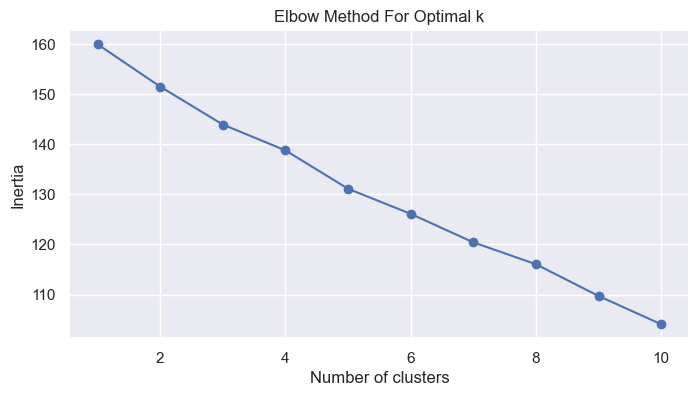

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt



# Determine the optimal number of clusters using the elbow method
inertia = []
for k in range(1, 11):  # Adjust range as needed
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(median_demand_normalized_row)
    inertia.append(kmeans.inertia_)
# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('kmeans1.png')
plt.show()

In [11]:
from sklearn.metrics import silhouette_score

# Assume X is your data and kmeans is your model
labels = kmeans.labels_
silhouette_avg = silhouette_score(median_demand_normalized_row, labels)
print(f"Average Silhouette Score: {silhouette_avg}")


Average Silhouette Score: 0.5297672564867485


In [13]:
unique_stations_start = trip_2207[['start_station_id']].drop_duplicates()
unique_stations_start = trip_2207.groupby('start_station_id').agg({'start_lat': 'mean', 'start_lng': 'mean'}).reset_index()

unique_stations_end = trip_2207[['end_station_id']].drop_duplicates()
unique_stations_end = trip_2207.groupby('end_station_id').agg({'end_lat': 'mean', 'end_lng': 'mean'}).reset_index()

names_start={"start_station_id":"station_id","start_lat":"lat","start_lng":"lng"}
unique_stations_start=unique_stations_start.rename(columns=names_start)
names_end={"end_station_id":"station_id","end_lat":"lat","end_lng":"lng"}
unique_stations_end=unique_stations_end.rename(columns=names_end)
station_id_stacked=pd.concat([unique_stations_start,unique_stations_end])
all_stations_id = unique_stations_start.drop_duplicates(subset=["station_id"])
all_stations_id

station_id        lat        lng
0           021320  41.890000 -87.680000
1             1011  41.920000 -87.790000
2             1012  41.802000 -87.610000
3             1013  41.890000 -87.730000
4             1016  41.990000 -87.720000
...            ...        ...        ...
1142  chargingstx0  41.932422 -87.652710
1143  chargingstx1  41.918321 -87.652229
1144  chargingstx3  41.883586 -87.648577
1145  chargingstx4  41.885528 -87.652316
1146  chargingstx5  41.943378 -87.670698

[1147 rows x 3 columns]

In [14]:
# Assuming 'station_id' is the common column in both DataFrames and is set as the index in 'median_demand_normalized_row'
# If 'station_id' is not the index, set it as the index


# Filter the 'all_stations_id' DataFrame to include only those rows where 'station_id' exists in 'median_demand_normalized_row'
workingdays_stations = all_stations_id[all_stations_id['station_id'].isin(median_demand_normalized_row.index)]
workingdays_stations
# Now 'filtered_stations' contains only the stations that are present in 'median_demand_normalized_row'


station_id        lat        lng
0           021320  41.890000 -87.680000
1             1011  41.920000 -87.790000
2             1012  41.802000 -87.610000
3             1013  41.890000 -87.730000
4             1016  41.990000 -87.720000
...            ...        ...        ...
1142  chargingstx0  41.932422 -87.652710
1143  chargingstx1  41.918321 -87.652229
1144  chargingstx3  41.883586 -87.648577
1145  chargingstx4  41.885528 -87.652316
1146  chargingstx5  41.943378 -87.670698

[1127 rows x 3 columns]

In [29]:
from sklearn.cluster import KMeans

# Run K-Means
kmeans = KMeans(n_clusters=4)  # Assum
workingdays_stations['cluster_label'] = kmeans.fit_predict(workingdays_stations[['lat', 'lng']])

workingdays_stations


C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yaqiong Wang\AppData\Local\Temp\ipykernel_22452\2697596513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workingdays_stations['cluster_label'] = kmeans.fit_predict(workingdays_stations[['lat', 'lng']])


station_id        lat        lng  cluster_label
0           021320  41.890000 -87.680000              2
1             1011  41.920000 -87.790000              0
2             1012  41.802000 -87.610000              1
3             1013  41.890000 -87.730000              0
4             1016  41.990000 -87.720000              0
...            ...        ...        ...            ...
1142  chargingstx0  41.932422 -87.652710              2
1143  chargingstx1  41.918321 -87.652229              2
1144  chargingstx3  41.883586 -87.648577              2
1145  chargingstx4  41.885528 -87.652316              2
1146  chargingstx5  41.943378 -87.670698              0

[1127 rows x 4 columns]

Average Silhouette Score for k=4: 0.39992067987149915


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming median_demand_normalized_row is your data
range_of_clusters = range(2, 10)  # Example range, adjust as necessary
silhouette_scores = []

for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(median_demand_normalized_row)
    score = silhouette_score(median_demand_normalized_row, labels)
    silhouette_scores.append(score)

# Print silhouette scores for each k
for k, score in zip(range_of_clusters, silhouette_scores):
    print(f"Silhouette Score for k={k}: {score}")


C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

Silhouette Score for k=2: 0.539909359170452
Silhouette Score for k=3: 0.6060446873475113
Silhouette Score for k=4: 0.5670013247660445
Silhouette Score for k=5: 0.5759793688200812
Silhouette Score for k=6: 0.4491622174808517
Silhouette Score for k=7: 0.457084163041221
Silhouette Score for k=8: 0.5186268125659983
Silhouette Score for k=9: 0.516229267885291


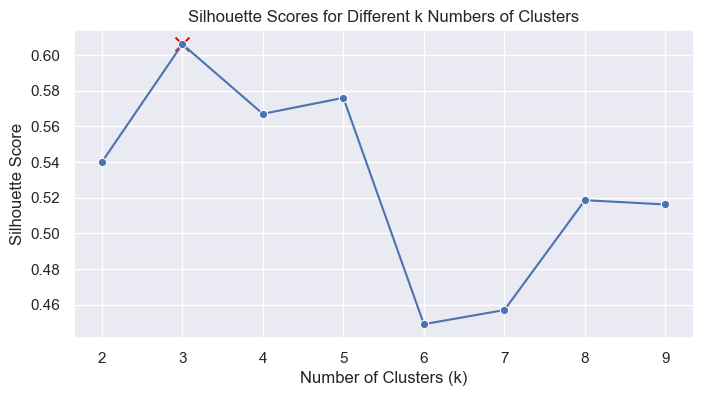

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your silhouette scores and corresponding k values
k_values = range(2, 10)
silhouette_scores = [0.539909359170452, 0.6060446873475113, 0.5670013247660445, 
                     0.5759793688200812, 0.4491622174808517, 0.457084163041221, 
                     0.5186268125659983, 0.516229267885291]

# Create a DataFrame for easier plotting
import pandas as pd
data = pd.DataFrame({'k': k_values, 'Silhouette Score': silhouette_scores})

# Create the line plot
plt.figure(figsize=(8, 4))
sns.lineplot(x='k', y='Silhouette Score', data=data, marker='o')
k_3_score = data[data['k'] == 3]['Silhouette Score'].values[0]
plt.scatter(3, k_3_score, color='red', marker='x', s=100) 

# Adding title and labels
plt.title('Silhouette Scores for Different k Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.savefig('silhouette scores.png')

# Show the plot
plt.show()


In [30]:
import random
import matplotlib.colors as mcolors
!pip install folium
import folium

m = folium.Map(location=[41.881832, -87.623177], zoom_start=10)
folium.GeoJson('Boundaries_chicago.geojson').add_to(m)
m
distinct_colors = ['rosybrown', 'gold', 'lightseagreen',"mediumpurple"]
# Iterate through your DataFrame to add markers for each data point with cluster-specific colors
for _, row in workingdays_stations.iterrows():
    cluster_label = row['cluster_label']
    color = distinct_colors[cluster_label]
    
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=1.5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        
    ).add_to(m)
m    

In [32]:
# Perform the merge without renaming by specifying left and right columns
trip_counts_weekdays_after = trip_counts_weekdays.merge(workingdays_stations[['station_id', 'cluster_label']],
                                                  left_on='start_station_id', 
                                                  right_on='station_id',
                                                  how='left')
trip_counts_weekdays_after.drop(['station_id'],axis=1, inplace=True)

# Optionally, you can drop the redundant 'station_id' column after the merge if it's created
trip_counts_weekdays_after

start_station_id    Weekday  calendar_week  start_hour  trip_count   
0                021320     Friday             26          10           1  \
1                021320     Friday             26          14           1   
2                021320     Friday             26          16           1   
3                021320     Friday             27          11           1   
4                021320     Friday             28          11           1   
...                 ...        ...            ...         ...         ...   
140021     chargingstx5  Wednesday             30          18           5   
140022     chargingstx5  Wednesday             30          19           8   
140023     chargingstx5  Wednesday             30          20           5   
140024     chargingstx5  Wednesday             30          21           5   
140025     chargingstx5  Wednesday             30          23           1   

        cluster_label  
0                   2  
1                   2  
2                   2  
3                   2  
4                   2  
...               ...  
140021              0  
140022              0  
140023              0  
140024              0  
140025              0  

[140026 rows x 6 columns]

In [34]:
cluster_demand = trip_counts_weekdays_after.groupby(['cluster_label', 'start_hour']).agg({'trip_count':'sum'}).reset_index()

# Pivot the table to have hours as columns and clusters as rows
cluster_demand_pivot = cluster_demand.pivot(index='cluster_label', columns='start_hour', values='trip_count')

# Melt the pivoted DataFrame to long format for plotting
cluster_demand_melted = cluster_demand_pivot.reset_index().melt(id_vars=['cluster_label'], var_name='hour', value_name='aggregate_demand')
cluster_demand_melted

cluster_label hour  aggregate_demand
0               0    0              1004
1               1    0               157
2               2    0              3632
3               3    0                98
4               0    1               556
..            ...  ...               ...
91              3   22               217
92              0   23              2141
93              1   23               295
94              2   23              7766
95              3   23               166

[96 rows x 3 columns]

result part

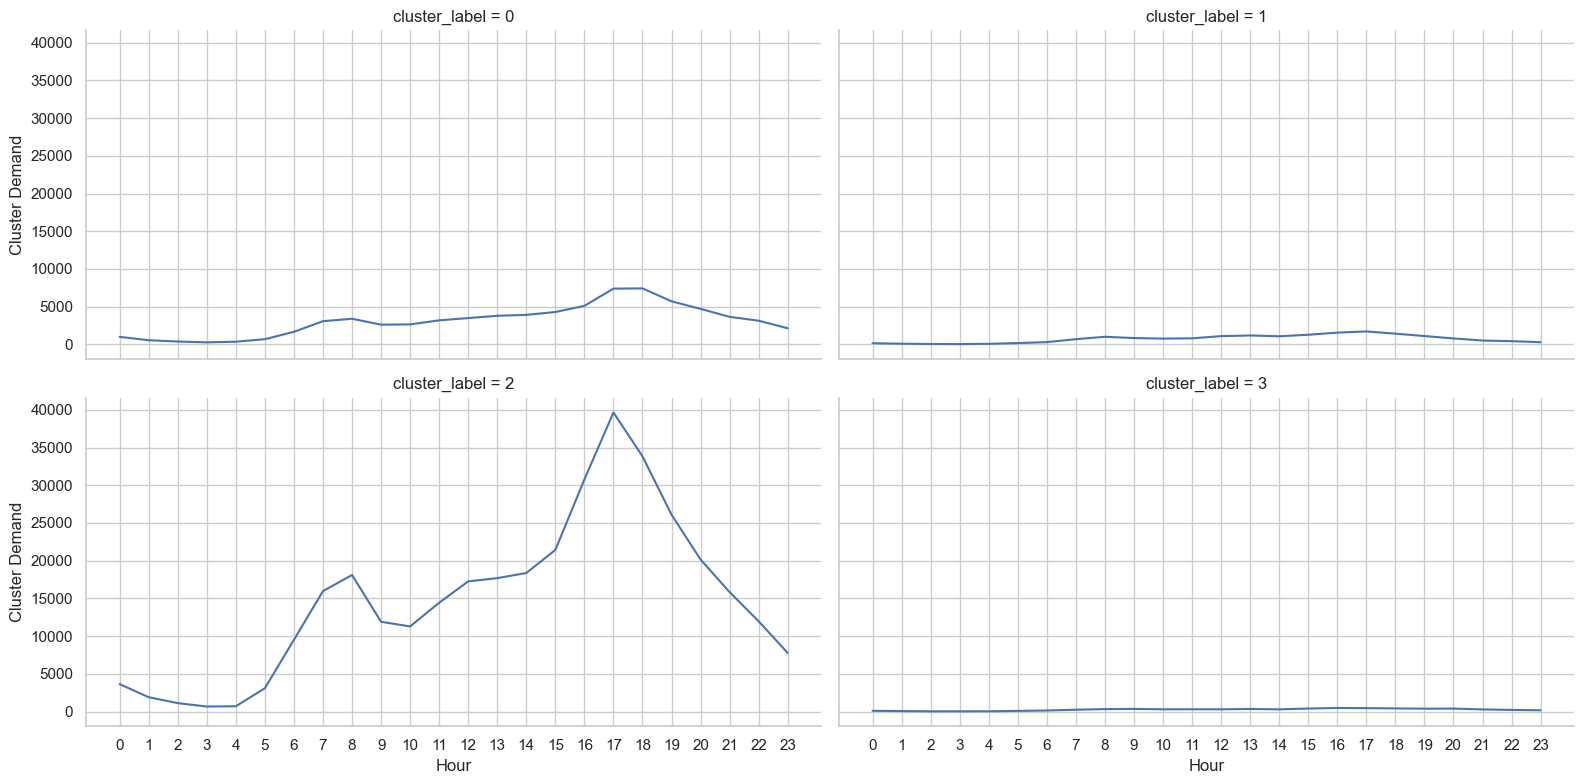

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
img_height = 4; img_width = 8
sns_plot = sns.relplot(data=cluster_demand_melted,
                       x='hour', y='aggregate_demand',
                       col='cluster_label', col_wrap=2, height=img_height, aspect=img_width/img_height,
                       kind='line', estimator='sum')

# Adjust x-ticks if necessary
sns_plot.set(xticks=range(0, 24)) # Set xtick labels to show every hour
sns_plot.set_axis_labels("Hour", "Cluster Demand")

# Save the plot to a file

plt.savefig('4cluster_demand.png')
# Show the plot
plt.show()

In [36]:
# Assuming 'all_stations_id' has the 'cluster_label' column
cluster_station_counts = workingdays_stations.groupby('cluster_label').size().reset_index(name='num_stations')
print(cluster_station_counts)


   cluster_label  num_stations
0              0           329
1              1           283
2              2           319
3              3           196


In [39]:
# Let's say you had a list of colors:
distinct_colors = ['rosybrown', 'gold', 'lightseagreen',"mediumpurple"]

# Create a dictionary that maps cluster labels to colors
cluster_color_mapping = dict(zip(range(len(distinct_colors)), distinct_colors))

# Now you can print or add this information to your DataFrame

cluster_station_counts['color'] = cluster_station_counts['cluster_label'].map(cluster_color_mapping)

print(cluster_station_counts)


   cluster_label  num_stations          color
0              0           329      rosybrown
1              1           283           gold
2              2           319  lightseagreen
3              3           196   mediumpurple


In [41]:
import pandas as pd
centroids = workingdays_stations.groupby('cluster_label').agg({'lat': 'mean', 'lng': 'mean'}).reset_index()
centroids.rename(columns={'lat': 'centroid_lat', 'lng': 'centroid_lng'}, inplace=True)

print(centroids)


   cluster_label  centroid_lat  centroid_lng
0              0     41.951843    -87.714938
1              1     41.740469    -87.615015
2              2     41.889604    -87.645302
3              3     41.827205    -87.701991


In [72]:
per_station = trip_counts_weekdays_after.groupby(['start_station_id', 'cluster_label'])['trip_count'].sum().reset_index()

# Step 2: Identify Maximum
k4busiest_stations = per_station.loc[per_station.groupby('cluster_label')['trip_count'].idxmax()]

# Step 3: Select Stations
k4selected_stations = k4busiest_stations['start_station_id'].tolist()
k4stations_hourly_demand = trip_counts_weekdays_after[trip_counts_weekdays_after['start_station_id'].isin(k4selected_stations)]
k4stations_hourly_demand=k4stations_hourly_demand.groupby(['start_station_id', 'start_hour']).agg(total_trip_count=('trip_count', 'sum')).reset_index()
k4stations_hourly_demand
k4busiest_stations

start_station_id  cluster_label  trip_count
31              13071              0        1913
1102     TA1309000037              1        1528
14              13022              2        7979
609               644              3         537

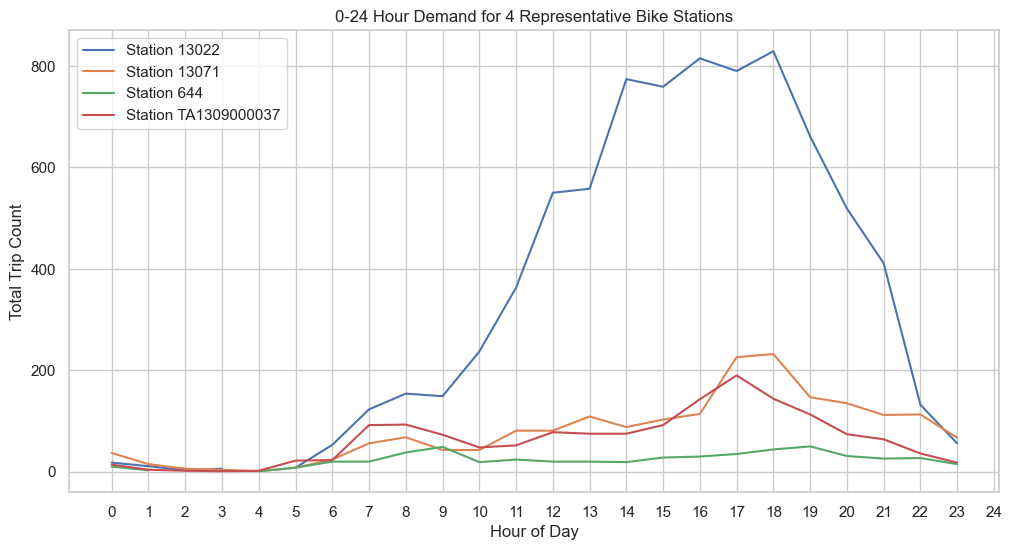

In [73]:
pivoted =k4stations_hourly_demand .pivot(index='start_hour', columns='start_station_id', values='total_trip_count')

# Step 3: Plot the data
plt.figure(figsize=(12, 6))
for column in pivoted.columns:
    plt.plot(pivoted.index, pivoted[column], label=f'Station {column}')

plt.title('0-24 Hour Demand for 4 Representative Bike Stations')
plt.xlabel('Hour of Day')
plt.ylabel('Total Trip Count')
plt.xticks(range(0, 25))
plt.legend()
plt.savefig('4stations_demand.png')
plt.show()

overall demand anaylsis

In [46]:
trip_2207['hour'] = trip_2207['started_at'].dt.hour

# Grouping by hour, Weekday, and calendar_week and counting the occurrences
hourly_demand = trip_2207.groupby(['hour', 'Weekday', 'calendar_week']).size().reset_index(name='pickup_demand_count')

# Pivoting the table to have each hour as a column
hourly_demand_pivot = hourly_demand.pivot_table(index=['Weekday', 'calendar_week'],
                                               columns='hour',
                                               values='pickup_demand_count',
                                               fill_value=0).reset_index()

# Resetting column names after pivot
hourly_demand_pivot.columns.name = None
hourly_demand_pivot.columns = ['Weekday', 'calendar_week'] + [str(i) for i in range(24)]

# Saving or displaying the resulting DataFrame
hourly_demand_pivot


Weekday  calendar_week     0    1    2    3    4    5    6     7  ...   
0      Friday             26   399  237  131   81   76  205  542   823  ...  \
1      Friday             27   351  173  115   63   72  189  628   892  ...   
2      Friday             28   400  228  123   82   78  190  540   566  ...   
3      Friday             29   357  168  146   92   76  243  611  1032  ...   
4      Friday             30   378  332  165   94   65  212  699   936  ...   
5      Monday             27   556  406  269  163  113  151  195   342  ...   
6      Monday             28   216   98   75   59   81  228  631  1062  ...   
7      Monday             29   221  129   80   67   66  230  625  1075  ...   
8      Monday             30   347  126  127   60   65  230  638  1060  ...   
9    Saturday             26   569  502  261  145   86  135  262   390  ...   
10   Saturday             27   866  572  281  169   87  146  249   479  ...   
11   Saturday             28   652  556  296  191  102  126  228   413  ...   
12   Saturday             29   718  561  324  172   74   21   54   257  ...   
13   Saturday             30   805  675  373  174   99  146  230   428  ...   
14     Sunday             26   745  467  363  171  104  109  212   343  ...   
15     Sunday             27  1030  653  373  231  130  191  286   357  ...   
16     Sunday             28   960  629  402  248  134   46  124   243  ...   
17     Sunday             29   934  591  417  219  109   49   50    72  ...   
18     Sunday             30   846  609  405  220  123  133  205   359  ...   
19   Thursday             27   231   94   59   54   65  247  652  1230  ...   
20   Thursday             28   256  155   71   43   81  223  711  1324  ...   
21   Thursday             29   304  114   92   56   56  251  686  1279  ...   
22   Thursday             30   333  134   83   55   48  204  616  1065  ...   
23    Tuesday             27   165   27   55   55   54  171  523   993  ...   
24    Tuesday             28   212  117   55   36   71  249  773  1384  ...   
25    Tuesday             29   226  114   61   38   82  254  774  1310  ...   
26    Tuesday             30   223  120   53   45   60  244  726  1308  ...   
27  Wednesday             27   130   51   15   18   56  137  452   992  ...   
28  Wednesday             28   242  159   85   41   66  237  716  1347  ...   
29  Wednesday             29   215  125   67   62   77  272  705  1310  ...   
30  Wednesday             30   226  138   56   39   66  246  676  1291  ...   

      14    15    16    17    18    19    20    21    22    23  
0   1351  1603  2031  2045  1875  1623  1329  1025   833   723  
1   1280  1694  1969  2252  2130  1645  1288  1025   999  1030  
2    923  1049   507   864   878   795   709   698   752   730  
3   1668  1934  2437  2777  2503  2018  1493  1214  1110   782  
4   2028  2143  2523  2743  2430  1840  1694  1258  1407  1108  
5   1891  1220  1459   748  1093  1258  1364  1171   914   563  
6   1077  1318  1935  2603  2300  1685  1341  1004   612   449  
7   1232  1564  2177  2859  2583  2014  1599  1044   721   381  
8   1268  1489  2058  2756  2386  1795  1334  1042   824   425  
9   2234  2365  2336  2232  2086  1703  1615  1594  1336   979  
10  2833  2756  2908  2794  2562  2067  1640  1560  1353  1314  
11  2370  2465  2462  2616  2272  1805  1364  1344  1477  1311  
12  2458  2574  2486  2427  2271  1776  1413  1488  1318  1135  
13  2524  2588  2431  2189  2146  1878  1545  1433  1567  1138  
14  2301  2397  2320  2270  2265  1871  1607  1271  1045   836  
15  2359  2415  2517  2362  2130  1707   922   779   567   359  
16  1848  1890  1894  1632  1458  1186  1015   870   743   369  
17  2011  2160  2072  2099  2096  1721  1347   849   808   667  
18  2387  2409  2363  2159  1911  1580  1207  1045   954   475  
19  1187  1494  2221  3017  2551  2017  1581  1262   913   566  
20  1429  1648  2452  3414  2954  2114  1577  1511  1209   731  
21  1278  1584  2219  3015  2558  1971  1602  1

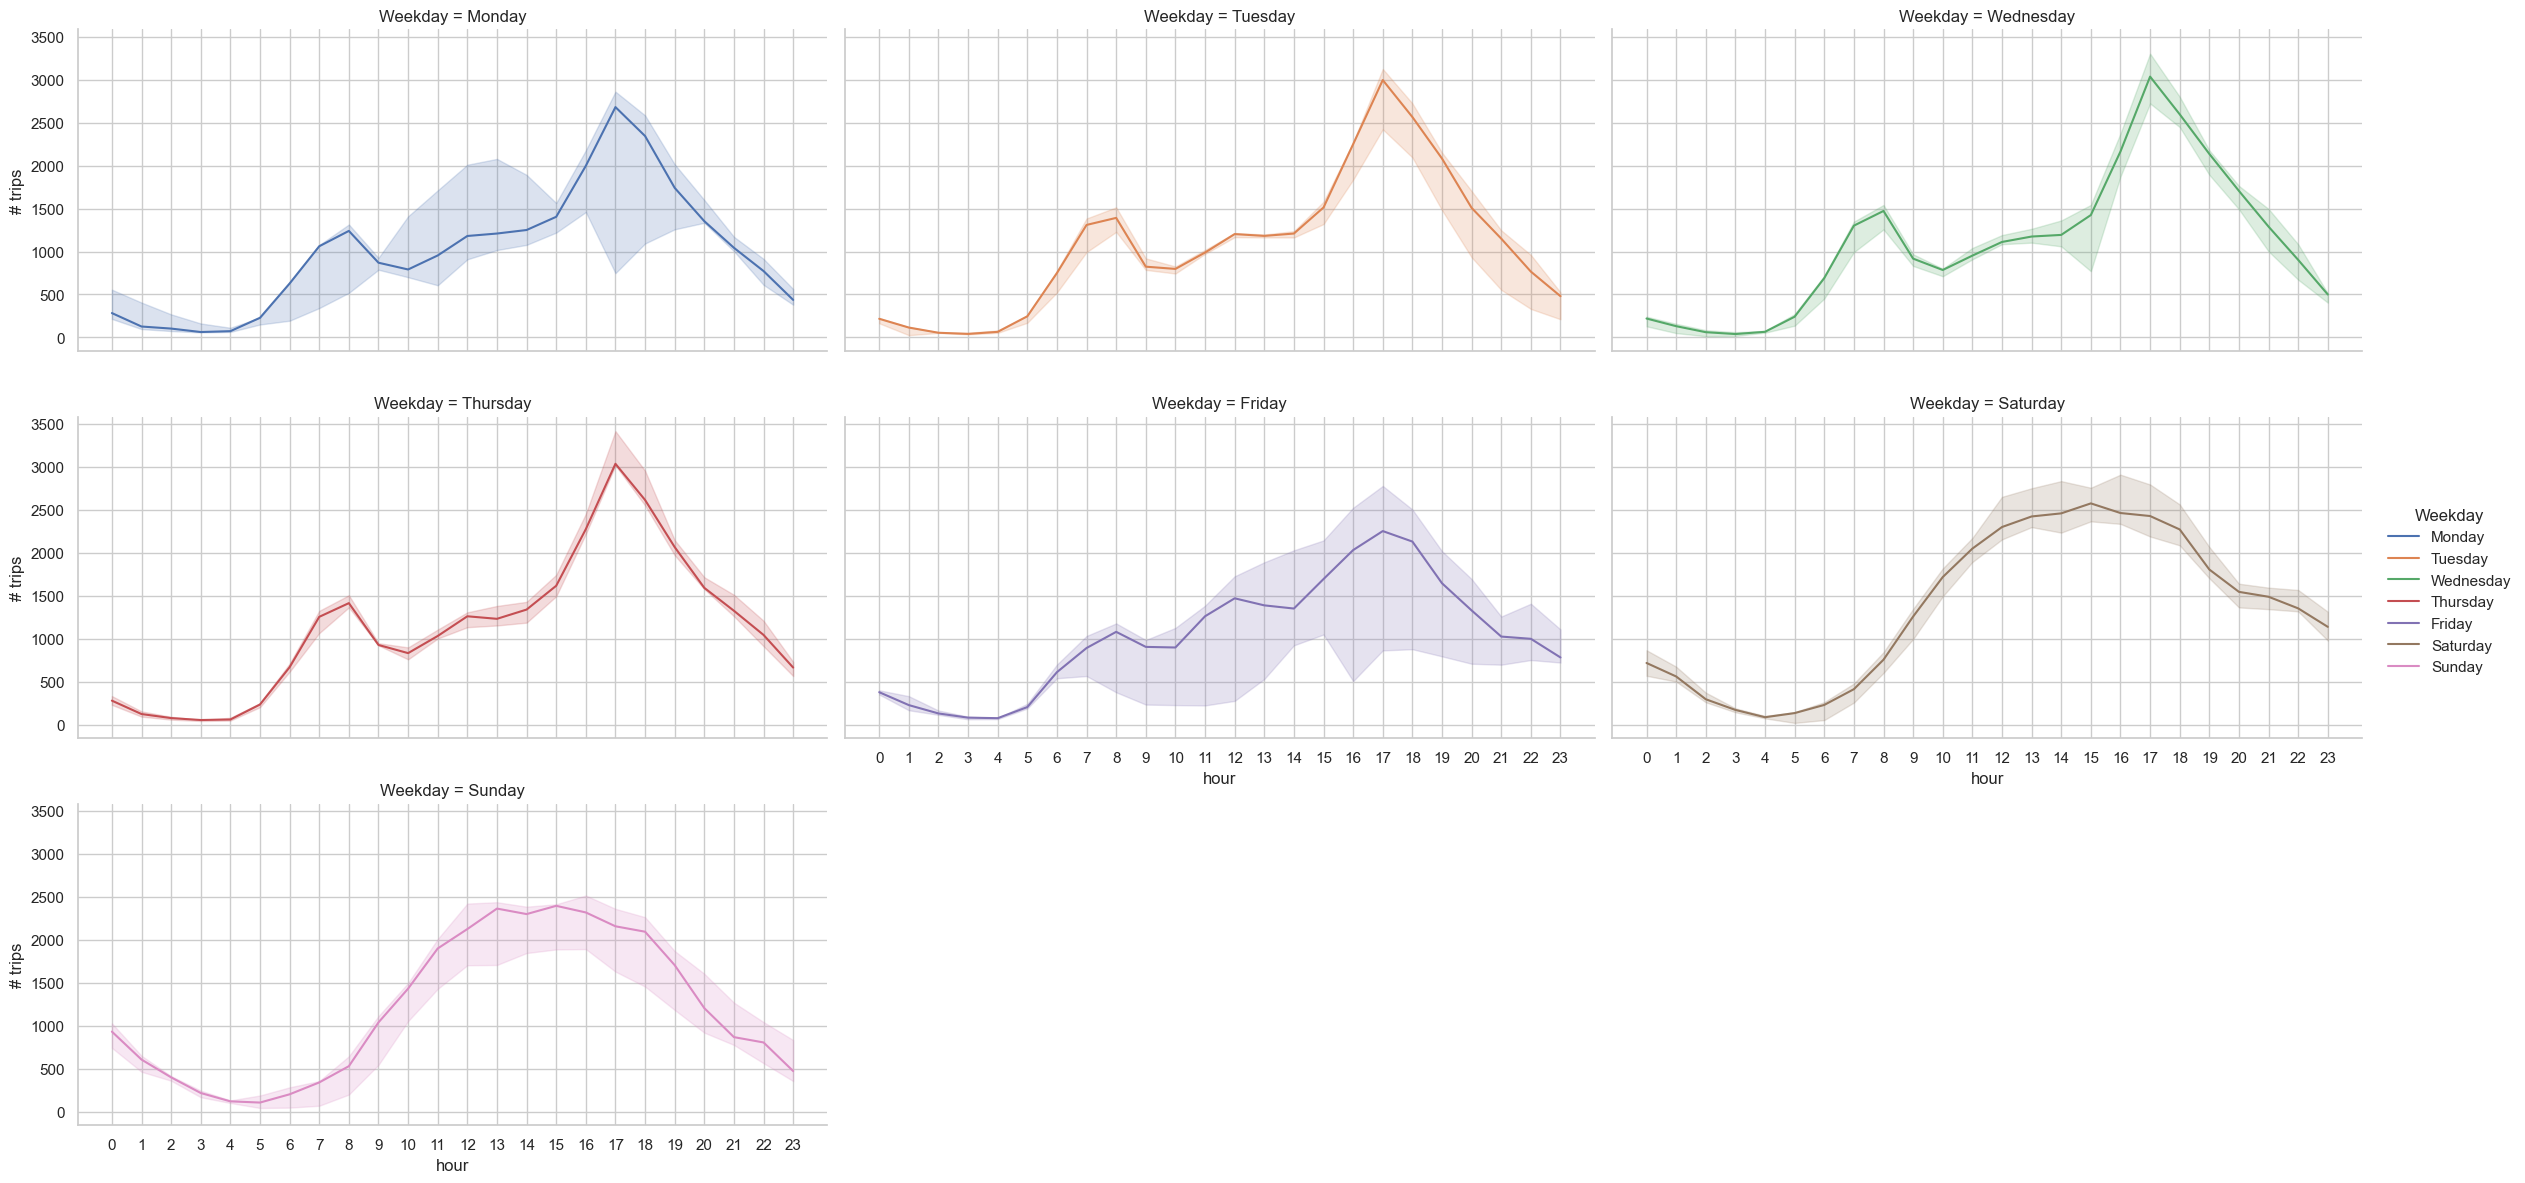

In [47]:
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
img_height = 4; img_width = 8

# Assuming hourly_demand_pivot is your DataFrame
sns_plot = sns.relplot(data=hourly_demand_pivot.melt(id_vars=['Weekday', 'calendar_week'], var_name='hour', value_name='pickup_demand_count'),
                       x='hour', y='pickup_demand_count',
                       col='Weekday', col_wrap=3, height=img_height, aspect=img_width/img_height,
                       hue='Weekday', kind='line', estimator=np.median,
                       hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                       col_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

sns_plot.set(xticks=hourly_demand_pivot.columns[2:].astype(int))  # Set xticks based on hour columns
sns_plot.set_xticklabels(hourly_demand_pivot.columns[2:])  # Set xtick labels based on hour columns
sns_plot.set(xlabel="hour", ylabel="# trips")
plt.savefig('hourly_demand.png')
sns_plot


In [48]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
weekdays_demand = hourly_demand_pivot[hourly_demand_pivot['Weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

# Let's sum up all the demand across the weekdays to get the overall demand time series
overall_demand_weekdays = weekdays_demand.sum(axis=0)[2:]  # Excluding 'Weekday' and 'calendar_week' columns

# Perform the Augmented Dickey-Fuller test to test over weeks stationarity
adf_result = adfuller(overall_demand_weekdays)

# Output the result
adf_result


(-8.505544144432886,
 1.2057062947358326e-13,
 9,
 14,
 {'1%': -4.01203360058309,
  '5%': -3.1041838775510207,
  '10%': -2.6909873469387753},
 243.65392289129224)

In [ ]:
#adf_result revised in paper

In [49]:
adf_weekday_results = {}

# List of weekdays to be considered
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Loop through the weekdays and perform the ADF test
for day in weekdays:
    # Extract the demand for the specific weekday across all weeks
    day_demand = hourly_demand_pivot[hourly_demand_pivot['Weekday'] == day].iloc[:, 2:].sum(axis=0)
    
    # Perform the ADF test on this aggregate demand
    adf_result = adfuller(day_demand)
    
    # Store the result
    adf_weekday_results[day] = adf_result

adf_weekday_results

{'Monday': (-3.627266349079544,
  0.005260646561602758,
  9,
  14,
  {'1%': -4.01203360058309,
   '5%': -3.1041838775510207,
   '10%': -2.6909873469387753},
  216.2391998954625),
 'Tuesday': (-6.017096131434193,
  1.5245000121854384e-07,
  9,
  14,
  {'1%': -4.01203360058309,
   '5%': -3.1041838775510207,
   '10%': -2.6909873469387753},
  209.6733367299255),
 'Wednesday': (-4.288555720631911,
  0.0004649254388590658,
  9,
  14,
  {'1%': -4.01203360058309,
   '5%': -3.1041838775510207,
   '10%': -2.6909873469387753},
  217.82110045286728),
 'Thursday': (-6.441674922837116,
  1.6024047375133595e-08,
  9,
  14,
  {'1%': -4.01203360058309,
   '5%': -3.1041838775510207,
   '10%': -2.6909873469387753},
  207.1700433736211),
 'Friday': (-3.9406199389686423,
  0.001755432817981208,
  9,
  14,
  {'1%': -4.01203360058309,
   '5%': -3.1041838775510207,
   '10%': -2.6909873469387753},
  213.6559849188511)}

In [ ]:
#stationlevel stationarity first across weeks, then across workingdays

In [60]:
stations_reject_h0 = 0
for station_id in hourly_demand_stationid_pivot['start_station_id'].unique():
    # Extract time series for each station
    station_series = hourly_demand_stationid_pivot[hourly_demand_stationid_pivot['start_station_id'] == station_id].iloc[:, 3:].values.flatten()

    # Perform ADF test
    adf_result = adfuller(station_series, autolag='AIC')
    adf_statistic, p_value = adf_result[0], adf_result[1]

    # Check if the null hypothesis is rejected (stationarity)
    if adf_statistic < adf_result[4]['5%'] and p_value < 0.05:
        stations_reject_h0 += 1

# Print the number of stations rejecting the null hypothesis
print(f"Number of stations rejecting the null hypothesis: {stations_reject_h0}")

C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Yaqiong Wang\AppData\Local\Prog

Number of stations rejecting the null hypothesis: 1118


C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [96]:
# Initialize DataFrame for results
adf_results_df = pd.DataFrame(columns=['station_id', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Rejections'])

# Loop over unique station IDs from weekday data
for station_id in hourly_demand_stationid_pivot['start_station_id'].unique():
# Initialize DataFrame for ADF test results

    rejections = 0
    results = {'station_id': station_id}

    for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
        # Extract time series and perform ADF test
        # ...

        # Check if the null hypothesis is rejected
        if adf_statistic < adf_result[4]['5%'] and p_value < 0.05:
            results[day] = 'Reject'
            rejections += 1
        else:
            results[day] = 'Fail to Reject'

    results['Rejections'] = rejections
    # Create a DataFrame for the current row and concatenate
    current_row = pd.DataFrame([results])
    adf_results_df = pd.concat([adf_results_df, current_row], ignore_index=True)

adf_results_df
# Count the number of stations with 5 rejections
stations_with_all_rejections = adf_results_df[adf_results_df['Rejections'] == 5].shape[0]

# Print the count
print(f"Number of stations with 5 rejections: {stations_with_all_rejections}")

Number of stations with 5 rejections: 1127


In [63]:
unique_station_count = hourly_demand_stationid_pivot["start_station_id"].nunique()
print(unique_station_count)

1127


In [116]:
busiest_station = trip_2207['start_station_id'].value_counts().idxmax()

# Filter the data for this station-----stationid=13022
busiest_station_data = trip_counts_weekdays[trip_counts_weekdays['start_station_id'] == busiest_station]
busiest_station_data
test_trip_counts = trip_counts_weekdays.groupby(['start_station_id', 'start_hour'])['trip_count'].sum().reset_index(name='sum_trip_count')
test_pivot_table = test_trip_counts.pivot(index='start_station_id', columns='start_hour', values='sum_trip_count')
test_pivot_table
test_station=test_pivot_table.loc['13022'].fillna(0)
test_station

start_hour
0      18.0
1      11.0
2       3.0
3       6.0
4       0.0
5       8.0
6      53.0
7     123.0
8     154.0
9     149.0
10    237.0
11    363.0
12    550.0
13    558.0
14    774.0
15    759.0
16    815.0
17    790.0
18    829.0
19    661.0
20    519.0
21    411.0
22    132.0
23     56.0
Name: 13022, dtype: float64

In [108]:
all_demand = test_pivot_table.sum()
all_demand

start_hour
0      4891.0
1      2611.0
2      1589.0
3      1010.0
4      1178.0
5      4055.0
6     11626.0
7     19986.0
8     22843.0
9     15714.0
10    15003.0
11    18730.0
12    22146.0
13    23013.0
14    23654.0
15    27405.0
16    37915.0
17    49220.0
18    43109.0
19    33308.0
20    26045.0
21    20289.0
22    15758.0
23    10368.0
dtype: float64

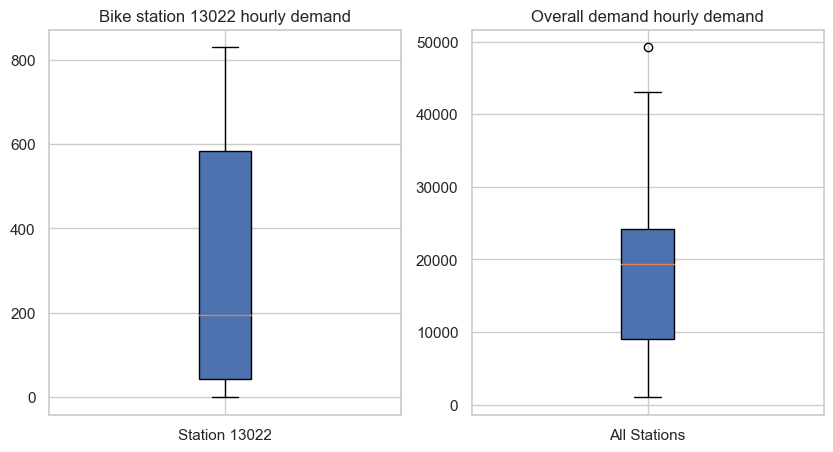

In [128]:
import matplotlib.pyplot as plt
import numpy as np

data1 = test_station
data2 = all_demand  # This should be a Series or array-like

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# First boxplot
axs[0].boxplot(data1, patch_artist=True)
axs[0].set_title('Bike station 13022 hourly demand')
axs[0].set_xticks([1])
axs[0].set_xticklabels(['Station 13022'])

axs[1].boxplot(data2, patch_artist=True)
axs[1].set_title('Overall demand hourly demand')
  # For the first plot
plt.xticks([1], ['All Stations']) 
plt.savefig('boxplot.png')
plt.show()


In [45]:
from sklearn.cluster import KMeans

# Run K-Means
kmeans = KMeans(n_clusters=3)  # Assum
workingdays_stations['cluster_label_1'] = kmeans.fit_predict(workingdays_stations[['lat', 'lng']])

workingdays_stations

C:\Users\Yaqiong Wang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yaqiong Wang\AppData\Local\Temp\ipykernel_22452\790416454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workingdays_stations['cluster_label_1'] = kmeans.fit_predict(workingdays_stations[['lat', 'lng']])


station_id        lat        lng  cluster_label  cluster_label_1
0           021320  41.890000 -87.680000              2                2
1             1011  41.920000 -87.790000              0                0
2             1012  41.802000 -87.610000              1                1
3             1013  41.890000 -87.730000              0                0
4             1016  41.990000 -87.720000              0                0
...            ...        ...        ...            ...              ...
1142  chargingstx0  41.932422 -87.652710              2                0
1143  chargingstx1  41.918321 -87.652229              2                0
1144  chargingstx3  41.883586 -87.648577              2                2
1145  chargingstx4  41.885528 -87.652316              2                2
1146  chargingstx5  41.943378 -87.670698              0                0

[1127 rows x 5 columns]

In [46]:
import matplotlib.colors as mcolors
!pip install folium
import folium

m = folium.Map(location=[41.881832, -87.623177], zoom_start=10)
folium.GeoJson('Boundaries_chicago.geojson').add_to(m)
m
distinct_colors = ['rosybrown', 'gold', 'lightseagreen']
# Iterate through your DataFrame to add markers for each data point with cluster-specific colors
for _, row in workingdays_stations.iterrows():
    cluster_label = row['cluster_label_1']
    color = distinct_colors[cluster_label]
    
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=1.5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        
    ).add_to(m)
m  

In [47]:
trip_counts_weekdays_afterk3 = trip_counts_weekdays.merge(workingdays_stations[['station_id', 'cluster_label_1']],
                                                  left_on='start_station_id', 
                                                  right_on='station_id',
                                                  how='left')
trip_counts_weekdays_afterk3.drop(['station_id'],axis=1, inplace=True)

# Optionally, you can drop the redundant 'station_id' column after the merge if it's created
trip_counts_weekdays_afterk3

start_station_id    Weekday  calendar_week  start_hour  trip_count   
0                021320     Friday             26          10           1  \
1                021320     Friday             26          14           1   
2                021320     Friday             26          16           1   
3                021320     Friday             27          11           1   
4                021320     Friday             28          11           1   
...                 ...        ...            ...         ...         ...   
140021     chargingstx5  Wednesday             30          18           5   
140022     chargingstx5  Wednesday             30          19           8   
140023     chargingstx5  Wednesday             30          20           5   
140024     chargingstx5  Wednesday             30          21           5   
140025     chargingstx5  Wednesday             30          23           1   

        cluster_label_1  
0                     2  
1                     2  
2                     2  
3                     2  
4                     2  
...                 ...  
140021                0  
140022                0  
140023                0  
140024                0  
140025                0  

[140026 rows x 6 columns]

In [48]:
cluster_demand_1 = trip_counts_weekdays_afterk3.groupby(['cluster_label_1', 'start_hour']).agg({'trip_count':'sum'}).reset_index()

# Pivot the table to have hours as columns and clusters as rows
cluster_demand_pivot_1 = cluster_demand_1.pivot(index='cluster_label_1', columns='start_hour', values='trip_count')

# Melt the pivoted DataFrame to long format for plotting
cluster_demand_melted_1 = cluster_demand_pivot_1.reset_index().melt(id_vars=['cluster_label_1'], var_name='hour', value_name='aggregate_demand')
cluster_demand_melted_1

cluster_label_1 hour  aggregate_demand
0                 0    0              2189
1                 1    0               158
2                 2    0              2544
3                 0    1              1252
4                 1    1                92
..              ...  ...               ...
67                1   22               428
68                2   22              8374
69                0   23              4635
70                1   23               288
71                2   23              5445

[72 rows x 3 columns]

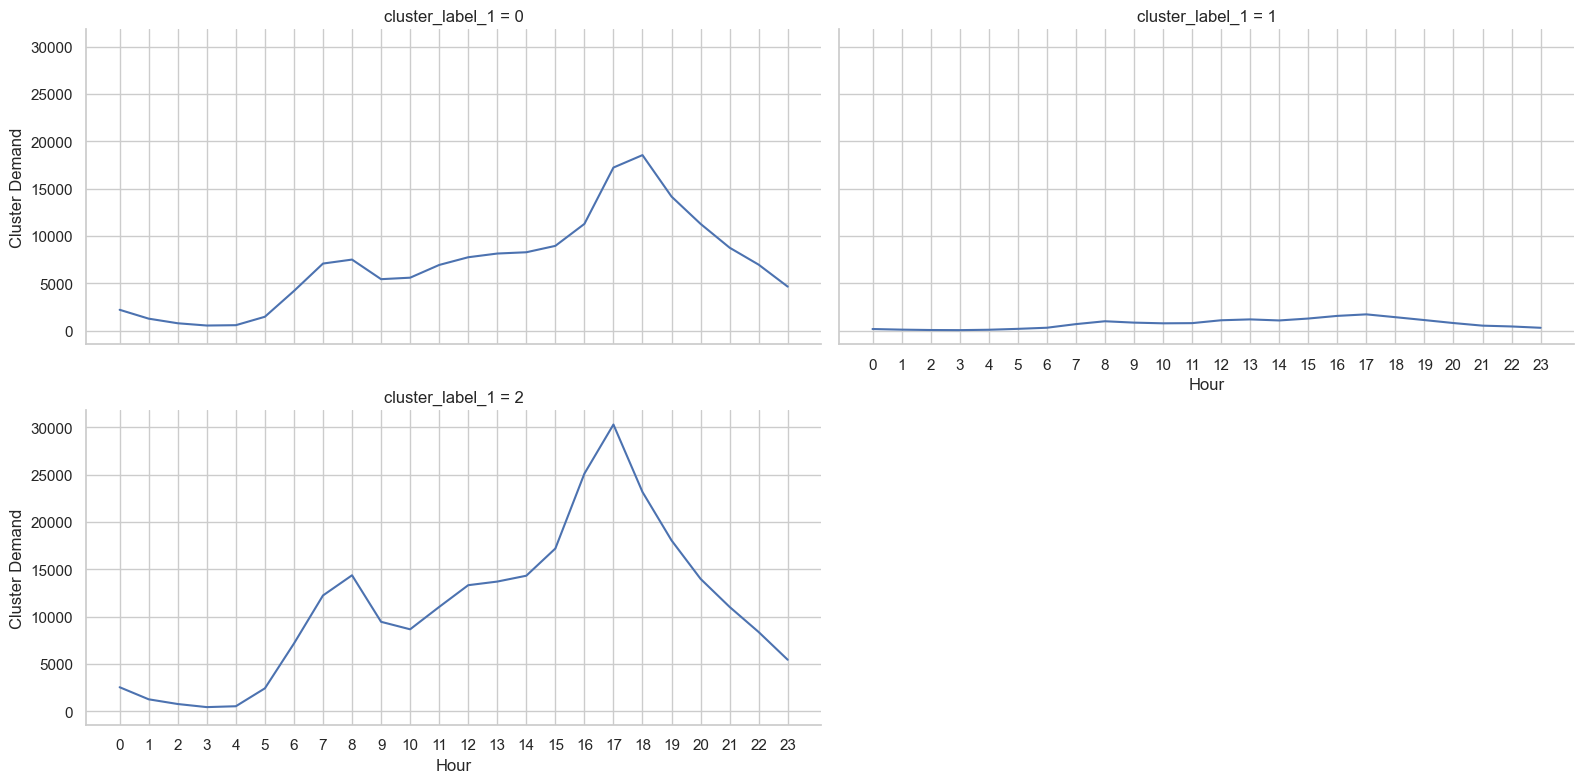

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
img_height = 4; img_width = 8
sns_plot = sns.relplot(data=cluster_demand_melted_1,
                       x='hour', y='aggregate_demand',
                       col='cluster_label_1', col_wrap=2, height=img_height, aspect=img_width/img_height,
                       kind='line', estimator='sum')

# Adjust x-ticks if necessary
sns_plot.set(xticks=range(0, 24)) # Set xtick labels to show every hour
sns_plot.set_axis_labels("Hour", "Cluster Demand")

# Save the plot to a file

plt.savefig('3cluster_demand.png')
# Show the plot
plt.show()

In [55]:
cluster_station_counts_1 = workingdays_stations.groupby('cluster_label_1').size().reset_index(name='num_stations')
print(cluster_station_counts_1)
distinct_colors = ['rosybrown', 'gold', 'lightseagreen']

# Create a dictionary that maps cluster labels to colors
cluster_color_mapping = dict(zip(range(len(distinct_colors)), distinct_colors))

# Now you can print or add this information to your DataFrame

cluster_station_counts_1['color'] = cluster_station_counts_1['cluster_label_1'].map(cluster_color_mapping)

print(cluster_station_counts_1)

   cluster_label_1  num_stations
0                0           411
1                1           282
2                2           434
   cluster_label_1  num_stations          color
0                0           411      rosybrown
1                1           282           gold
2                2           434  lightseagreen


In [56]:
centroids_1 = workingdays_stations.groupby('cluster_label_1').agg({'lat': 'mean', 'lng': 'mean'}).reset_index()
centroids_1.rename(columns={'lat': 'centroid_lat_1', 'lng': 'centroid_lng_1'}, inplace=True)

print(centroids_1)


   cluster_label_1  centroid_lat_1  centroid_lng_1
0                0       41.945683      -87.706121
1                1       41.739497      -87.616262
2                2       41.855786      -87.665216


In [70]:
total_trips_per_station = trip_counts_weekdays_afterk3.groupby(['start_station_id', 'cluster_label_1'])['trip_count'].sum().reset_index()

# Step 2: Identify Maximum
busiest_stations = total_trips_per_station.loc[total_trips_per_station.groupby('cluster_label_1')['trip_count'].idxmax()]

# Step 3: Select Stations
selected_stations = busiest_stations['start_station_id'].tolist()
stations_hourly_demand = trip_counts_weekdays_afterk3[trip_counts_weekdays_afterk3['start_station_id'].isin(selected_stations)]
stations_hourly_demand=stations_hourly_demand.groupby(['start_station_id', 'start_hour']).agg(total_trip_count=('trip_count', 'sum')).reset_index()
stations_hourly_demand
busiest_stations

start_station_id  cluster_label_1  trip_count
1051     TA1308000001                0        3562
1102     TA1309000037                1        1528
14              13022                2        7979

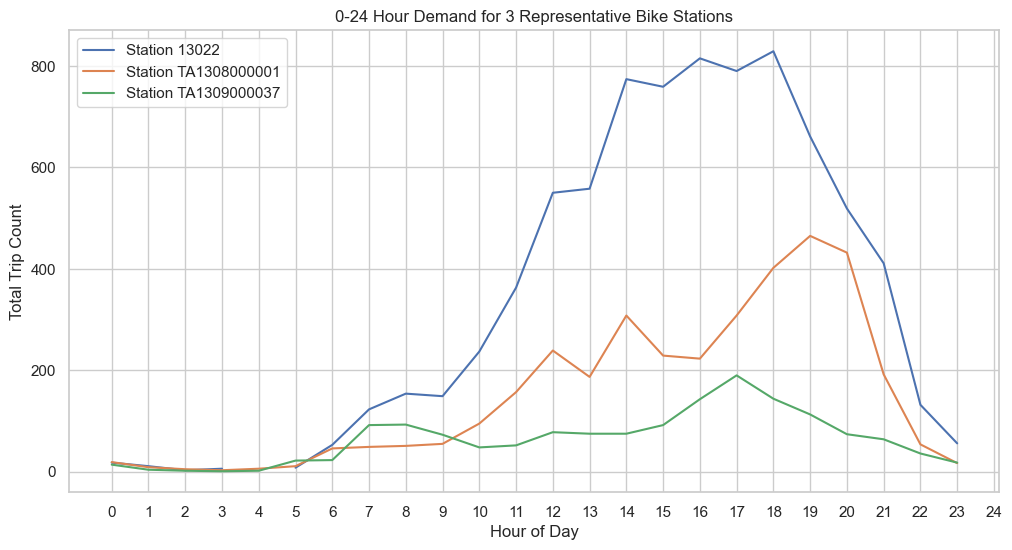

In [71]:



# Step 2: Pivot the data
pivoted_df =stations_hourly_demand .pivot(index='start_hour', columns='start_station_id', values='total_trip_count')

# Step 3: Plot the data
plt.figure(figsize=(12, 6))
for column in pivoted_df.columns:
    plt.plot(pivoted_df.index, pivoted_df[column], label=f'Station {column}')

plt.title('0-24 Hour Demand for 3 Representative Bike Stations')
plt.xlabel('Hour of Day')
plt.ylabel('Total Trip Count')
plt.xticks(range(0, 25))
plt.legend()
plt.savefig('3stations_demand.png')
plt.show()
